In [47]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

import yfinance as yf

In [48]:
start = '2010-01-01'
end = '2023-03-20'

aapl = yf.download('AAPL', start=start, end=end)
print(aapl.head())

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.505280  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.516528  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.412872  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.401019  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.443573  447610800


In [49]:
# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl['Close'].values.reshape(-1,1))

In [50]:
step = 90

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [68]:
print(train_data)
print(test_data)

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.565699  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.873638  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.875885  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.210682  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.140913  237458000
...               ...        ...        ...        ...        ...        ...
2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517090   48478800
2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896324   93121200
2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869431  146266000
2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290054  144114400
2019-12-31  72.482498  73.419998  72.379997  73.412498  71.810936  100805600

In [51]:
# Create training data
X_train = []
y_train = []
for i in range(step, train_size):
    X_train.append(train_data[i-step:i])
    y_train.append(train_data[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Create testing data
X_test = []
y_test = []
for i in range(step, len(test_data)):
    X_test.append(test_data[i-step:i])
    y_test.append(test_data[i])
X_test, y_test = np.array(X_test), np.array(y_test)

In [52]:
# Create LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

print(model.summary())

# Compile model
learning_rate = 0.001
adam = Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=adam)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 90, 50)            10400     
                                                                 
 dropout_15 (Dropout)        (None, 90, 50)            0         
                                                                 
 lstm_16 (LSTM)              (None, 90, 50)            20200     
                                                                 
 dropout_16 (Dropout)        (None, 90, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

None


In [53]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
81/81 [==============================] - 12s 70ms/step - loss: 0.0020
Epoch 2/15
81/81 [==============================] - 6s 71ms/step - loss: 4.5148e-04
Epoch 3/15
81/81 [==============================] - 6s 77ms/step - loss: 3.9092e-04
Epoch 4/15
81/81 [==============================] - 6s 69ms/step - loss: 3.4744e-04
Epoch 5/15
81/81 [==============================] - 6s 69ms/step - loss: 3.1980e-04
Epoch 6/15
81/81 [==============================] - 6s 68ms/step - loss: 3.0616e-04
Epoch 7/15
81/81 [==============================] - 6s 70ms/step - loss: 2.6953e-04
Epoch 8/15
81/81 [==============================] - 6s 72ms/step - loss: 3.1546e-04
Epoch 9/15
81/81 [==============================] - 6s 71ms/step - loss: 2.6341e-04
Epoch 10/15
81/81 [==============================] - 6s 73ms/step - loss: 2.4325e-04
Epoch 11/15
81/81 [==============================] - 6s 72ms/step - loss: 2.2048e-04
Epoch 12/15
81/81 [==============================] - 6s 71ms/step - loss: 2.2

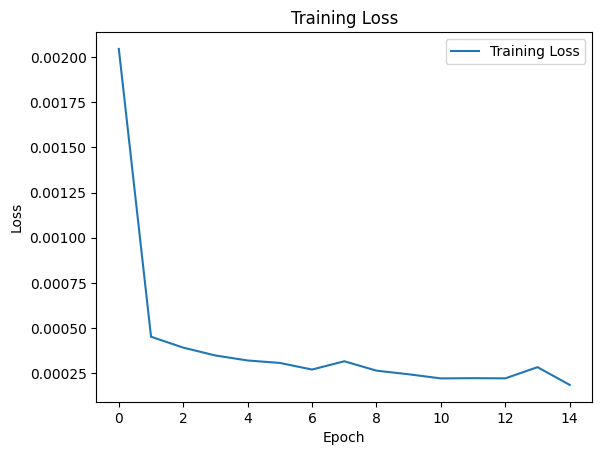

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

18/18 [==============================] - 2s 26ms/step


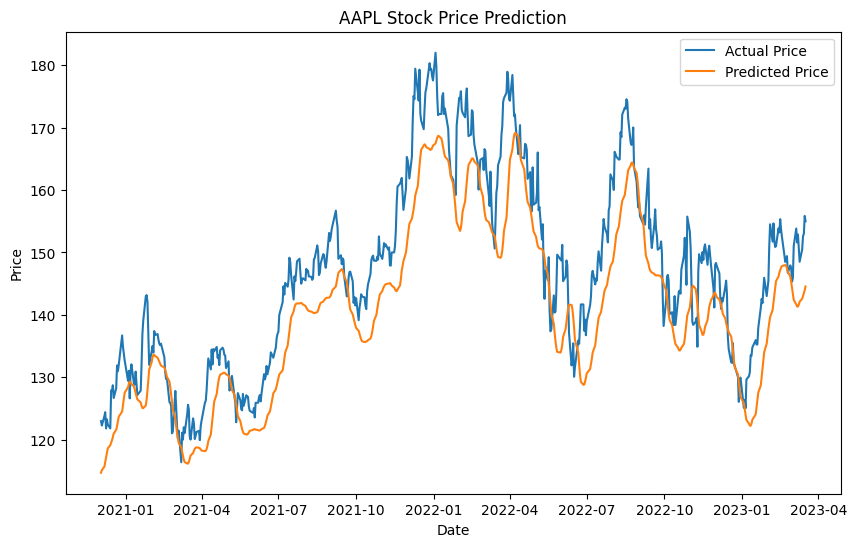

In [56]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(aapl.index[train_size+step:], aapl['Close'][train_size+step:], label='Actual Price')
plt.plot(aapl.index[train_size+step:], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

Separate Script

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.565701  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.873642  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.875889  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.210682  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.140911  237458000
...               ...        ...        ...        ...        ...        ...
2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517090   48478800
2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896339   93121200
2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869431  146266000
2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290047  144114400
2019-12

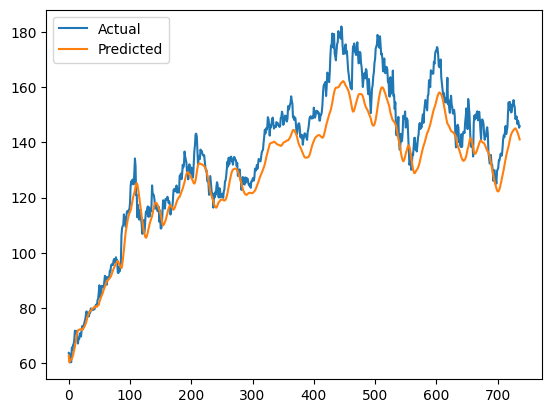

In [72]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# Download stock price data
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-03-03"
data = yf.download(ticker, start=start_date, end=end_date)

# Split data into training and testing sets
train_data = data[:'2019']
test_data = data['2020':]

new = {Date: , Open: , Low: Close: Adj Close: , Volume: 48478800}

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data["Close"].values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data["Close"].values.reshape(-1, 1))

print(train_data)
print(test_data)

# Define sliding window parameters
lookback = 60
stride = 5

# Create sliding window function
def create_sliding_window(data, lookback, stride):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(np.concatenate((data[i-lookback:i], [data[i-lookback-1]])))
        y.append(data[i])
    return np.array(X), np.array(y)

# Create training and testing sets using sliding window approach
X_train, y_train = create_sliding_window(train_data_scaled, lookback, stride)
X_test, y_test = create_sliding_window(test_data_scaled, lookback, stride)

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(lookback+1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Make predictions on test set
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predictions and actual values
import matplotlib.pyplot as plt
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.565699  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.873644  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.875893  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.210680  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.140913  237458000
...               ...        ...        ...        ...        ...        ...
2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517082   48478800
2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896317   93121200
2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869415  146266000
2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290062  144114400
2019-12

ValueError: x and y must have same first dimension, but have shapes (100,) and (40, 1)

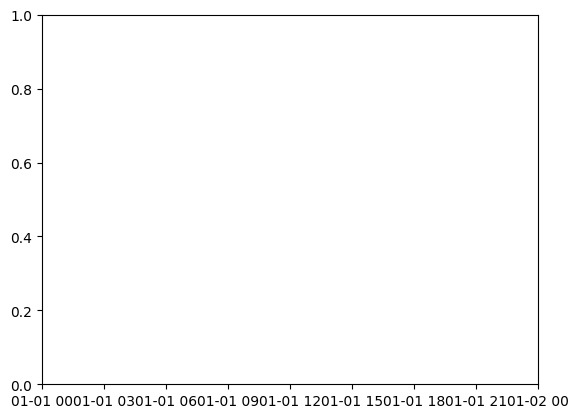

In [75]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Download stock price data
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-03-03"
data = yf.download(ticker, start=start_date, end=end_date)

# Split data into training and testing sets
train_data = data[:'2019']
test_data = data['2020':]

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data["Close"].values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data["Close"].values.reshape(-1, 1))

print(train_data)
print(test_data)

# Define sliding window parameters
lookback = 60
stride = 5

# Create sliding window function
def create_sliding_window(data, lookback, stride):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(np.concatenate((data[i-lookback:i], [data[i-lookback-1]])))
        y.append(data[i])
    return np.array(X), np.array(y)

# Create training and testing sets using sliding window approach
X_train, y_train = create_sliding_window(train_data_scaled, lookback, stride)
X_test, y_test = create_sliding_window(test_data_scaled, lookback, stride)

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(lookback+1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Make predictions on test set and future dates
future_dates = pd.date_range(start='2023-03-03', periods=100)
print(future_dates)
future_dates_scaled = scaler.transform(np.zeros((100,1)))
X_future, _ = create_sliding_window(future_dates_scaled, lookback, stride)
X_future_dates = np.concatenate((test_data_scaled[-lookback-1:], future_dates_scaled))

y_test_pred = model.predict(X_test)
y_future_pred = model.predict(X_future)

# Inverse scale the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = scaler.inverse_transform(y_test_pred)
y_future_pred_inv = scaler.inverse_transform(y_future_pred)

# Plot the predictions and actual values
test_dates = test_data.index[lookback+1::stride]
test_dates_pred = test_dates[lookback+1::stride]
#plt.plot(test_dates_pred, y_test_inv, label="Actual")
#plt.plot(test_dates_pred, y_test_pred_inv, label="Predicted")
plt.plot(future_dates, y_future_pred_inv, label="Future")
plt.legend()
plt.show()

# Number of periods to predict into the future
n_periods = 30

# Create an array of future dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=n_periods+1, freq='B')[1:]

# Scale the future values
future_values_scaled = scaler.transform(future_values.reshape(-1, 1))

# Create sliding window for future values
X_future, _ = create_sliding_window(future_values_scaled, lookback, stride)

# Predict future values
y_future = model.predict(X_future)

# Inverse scale the predicted values
y_future_inv = scaler.inverse_transform(y_future)

# Plot the predicted values for the future dates
plt.plot(future_dates, y_future_inv, label="Future Predictions")
plt.legend()
plt.show()


In [76]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Download stock price data
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-03-03"
data = yf.download(ticker, start=start_date, end=end_date)

# Split data into training and testing sets
train_data = data[:'2019']
test_data = data['2020':]

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data["Close"].values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data["Close"].values.reshape(-1, 1))

# Define sliding window parameters
lookback = 60
stride = 5

# Create sliding window function
def create_sliding_window(data, lookback, stride):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(np.concatenate((data[i-lookback:i], [data[i-lookback-1]])))
        y.append(data[i])
    return np.array(X), np.array(y)

# Create training and testing sets using sliding window approach
X_train, y_train = create_sliding_window(train_data_scaled, lookback, stride)
X_test, y_test = create_sliding_window(test_data_scaled, lookback, stride)

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(lookback+1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Add future dates for prediction
future_dates = pd.date_range(start=end_date, periods=30, freq='D')[1:]
future_dates_scaled = scaler.transform(np.zeros((30,1))) # Dummy values for scaling purposes

# Create sliding window for future dates
X_future, _ = create_sliding_window(future_dates_scaled, lookback, stride)

# Make predictions on test set and future dates
y_pred = model.predict(np.concatenate((X_test, X_future)))
y_pred_future = y_pred[len(y_test):]

# Inverse scale the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_future_inv = scaler.inverse_transform(y_pred_future)

# Plot the predictions and actual values
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv[:len(y_test)], label="Predicted")
plt.plot(np.arange(len(y_test), len(y_test)+len(y_pred_future)), y_pred_future_inv, label="Future Predicted")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
Epoch 1/10
38/38 [==============================] - 3s 35ms/step - loss: 0.0231 - val_loss: 0.2770
Epoch 2/10
38/38 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0866
Epoch 3/10
38/38 [==============================] - 1s 22ms/step - loss: 6.5521e-04 - val_loss: 0.0782
Epoch 4/10
38/38 [==============================] - 1s 22ms/step - loss: 6.7082e-04 - val_loss: 0.0843
Epoch 5/10
38/38 [==============================] - 1s 21ms/step - loss: 6.1033e-04 - val_loss: 0.0640
Epoch 6/10
38/38 [==============================] - 1s 22ms/step - loss: 6.0006e-04 - val_loss: 0.0666
Epoch 7/10
38/38 [==============================] - 1s 21ms/step - loss: 6.5311e-04 - val_loss: 0.0475
Epoch 8/10
38/38 [==============================] - 1s 21ms/step - loss: 5.6177e-04 - val_loss: 0.0415
Epoch 9/10
38/38 [==============================] - 1s 20ms/step - loss: 5.3712e-04 - val_loss: 0.0505
Epoch 10/10


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

[*********************100%***********************]  1 of 1 completed


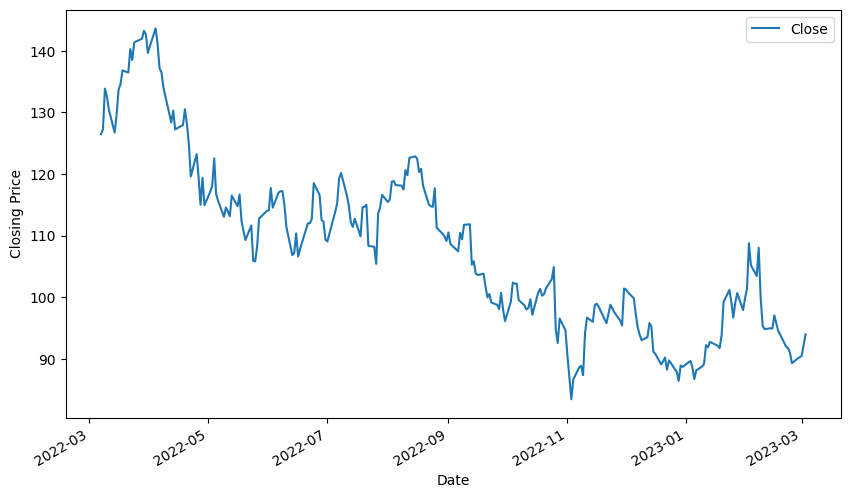

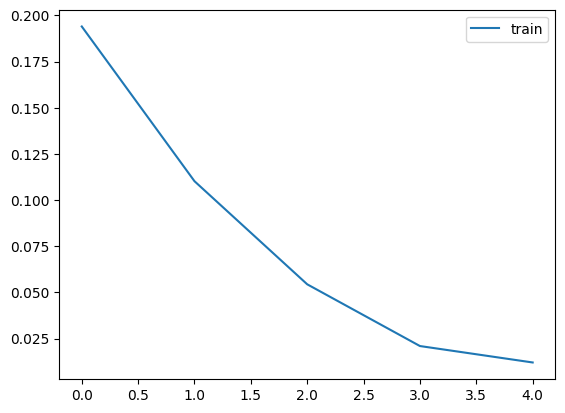

c:\Users\Christopher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# Define function to create sliding windows
def create_sliding_window(data, lookback, stride):
    X, y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback)])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

# Import data
symbol = 'GOOG'
start_date = '2022-03-06'
end_date = '2023-03-06'
df = yf.download(symbol, start=start_date, end=end_date)

# Get closing price
df = df[['Close']]

# Plot data
df.plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Scale data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

# Split data into train and test sets
lookback = 60
stride = 1
train_size = int(len(scaled_df) * 0.8)
test_size = len(scaled_df) - train_size
train_data, test_data = scaled_df[0:train_size,:], scaled_df[train_size:len(scaled_df),:]

# Create sliding windows for train and test sets
X_train, y_train = create_sliding_window(train_data, lookback, stride)
X_test, y_test = create_sliding_window(test_data, lookback, stride)

# Define and train LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=0, shuffle=False)

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Generate future dates to predict stock prices for
future_dates = pd.date_range(start='2023-03-06', end='2023-03-13', freq='B')

# Scale the future dates
future_dates_scaled = scaler.transform(np.array(future_dates).reshape(-1, 1))

# Create sliding windows for future dates
X_future, _ = create_sliding_window(future_dates_scaled, lookback, stride)

# Make predictions on test set and future dates
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_pred_future = y_pred[len(y_test):]

# Plot actual and predicted prices
plt.plot(df.index[-len(y_test):], y_test, label='actual')
plt.plot(future_dates, y_pred_future, label='predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
